<a href="https://colab.research.google.com/github/Pumafi/problem_solving_rl_pumafi/blob/main/initial_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ARC-AGI

Ferdinand Bhavsar

PhD student, Mines Paris

In [1]:
RUNNING_IN_COLAB = True

%cd /content

if RUNNING_IN_COLAB:
    REPO_URL = 'https://github.com/Pumafi/problem_solving_rl_pumafi'
    BRANCH   = 'main'
    REPO_DIR = 'problem_solving_rl_pumafi'

    from pathlib import Path

    if Path(REPO_DIR).is_dir():
      !rm -rf {REPO_DIR}

    # Download the repository
    if not Path(REPO_DIR).is_dir():
        !git clone --branch {BRANCH} --depth=1 -- {REPO_URL} {REPO_DIR}

    %cd {REPO_DIR}

/content
Cloning into 'problem_solving_rl_pumafi'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 397.67 KiB | 2.92 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/problem_solving_rl_pumafi


### Imports

In [2]:
from tensorflow import keras
import pandas as pd
import numpy as np

import random
import math
from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
from matplotlib import colors


from scipy.stats import kde
from sklearn.metrics.pairwise import euclidean_distances

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras import layers, losses
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

In [3]:
# Load code from the repo
from utils.data_handling import get_color_map, pad_to_shape, preprocess_challenge_data
from utils.noising_grids import create_fail

### Utilities

Get color map (took from some random code I had lying around, so the colors are not the ones from ARC-AGI

### Dataset Loading

In [4]:
import json

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

training_challenges = load_json('./data/arc-agi_training_challenges.json')
training_solutions = load_json('./data/arc-agi_training_solutions.json')
evaluation_challenges = load_json('./data/arc-agi_evaluation_challenges.json')

print("Data loaded successfully.")
print(f"Training tasks: {len(training_challenges)}")
print(f"Evaluation tasks: {len(evaluation_challenges)}")

Data loaded successfully.
Training tasks: 400
Evaluation tasks: 400


Preprocess the challenge data (I'm not touching the indentation, it was a nightmare of using jupyter AND colab for some tests)

In [5]:
challenge_propositioner_inputs, train_solver_inputs, train_solver_outputs, test_solver_inputs, test_solver_outputs = preprocess_challenge_data(training_challenges, training_solutions)
print(len(challenge_propositioner_inputs), len(train_solver_inputs), len(train_solver_outputs), len(test_solver_inputs), len(test_solver_outputs))

400 400 400 400 400


In [6]:
# visualize data types
print(type(challenge_propositioner_inputs))
print(type(challenge_propositioner_inputs[0]))
print(type(challenge_propositioner_inputs[0][0]))
print(type(challenge_propositioner_inputs[0][0][0]))

<class 'list'>
<class 'list'>
<class 'tuple'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [7]:
# In order of access we have:
#     challenge_propositioner_inputs [problem_nb (list)] [example_nb (list)] [0/1 - input/output (tuple)] -> [30, 30, 10] (ndarray)

# Visualize the size of examples sets (NB: All have at least 2 examples, but 2 is to few for my idea)
for i in range(5):
  print("Problem nb ", i +1, " | nb examples: ", len(challenge_propositioner_inputs[i]))

print("\nSize of one grid: ", challenge_propositioner_inputs[0][0][0].shape)

Problem nb  1  | nb examples:  5
Problem nb  2  | nb examples:  5
Problem nb  3  | nb examples:  3
Problem nb  4  | nb examples:  2
Problem nb  5  | nb examples:  3

Size of one grid:  (30, 30, 10)


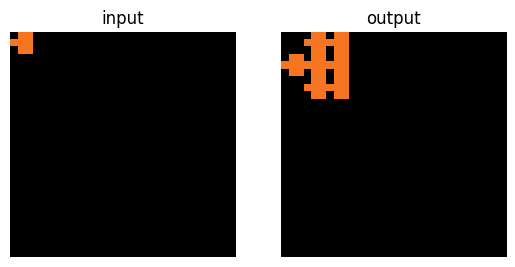

In [8]:
cmap, norm = get_color_map(number_of_categories=9)

plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(np.argmax(challenge_propositioner_inputs[0][0][0], axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('output')
plt.imshow(np.argmax(challenge_propositioner_inputs[0][0][1], axis=-1), interpolation='nearest', cmap=cmap, norm=norm)
plt.axis('off')
plt.show()

In [9]:
# Idea: create sub-array of fixed sized with success/fail examples
# [X] 1) create a fail function that creates failes examples (random noise & rotation & color translation& random selection)
# [X] 2) Remove the challenges with only two examples (we want at least 2 success)
# [X] 3) Split challenges with more than 6 examples (6 into 3/3, 7 into 4/3, 8 into 4/4, 9 into 5/4, 10 into 4/3/3)
# [X] 4) Isolate for each task 2 successes
# [ ] 5) The rest has to be completed with failure

In [10]:
#def create_fail(challenge_grids):
#    ...
#    return challenge_grids, labels

In [11]:
tmp_test_structure = challenge_propositioner_inputs[3].copy()
tmp_output_test, labels = create_fail(tmp_test_structure)

print(len(challenge_propositioner_inputs[3]), len(tmp_output_test))

2 4


In [15]:
def split_list(lst):
    if len(lst) <= 2:
        return []  # Remove lists with 1 or 2 elements
    if len(lst) <= 6:
        return [lst]
    split_sizes = {6: [3, 3], 7: [4, 3], 8: [4, 4], 9: [5, 4], 10: [5, 5]}

    if len(lst) in split_sizes:
        sizes = split_sizes[len(lst)]
        parts = []
        index = 0
        for size in sizes:
            parts.append(lst[index:index + size])
            index += size
        return parts
    else:
        # General case for lists >10: split into chunks of 4 or 5 alternately
        parts = []
        index = 0
        toggle = True  # Alternate between 4 and 5
        while len(lst) - index > 5:
            parts.append(lst[index:index + (4 if toggle else 5)])
            index += 4 if toggle else 5
            toggle = not toggle
        parts.append(lst[index:])  # Add the remaining part
        return parts


def process_inputs(inputs):
    filtered_and_split = []
    for sublist in inputs:
        if len(sublist) > 1:  # Remove lists with 1 or 2 elements
            filtered_and_split.extend(split_list(sublist))
    return filtered_and_split

# Example usage:
# Assuming challenge_propositioner_inputs is defined
processed_inputs = process_inputs(challenge_propositioner_inputs)

In [16]:
def split_into_two_lists(processed_inputs):
    list_of_pairs = []
    remaining_list = []

    for sublist in processed_inputs:
        if len(sublist) >= 2:
            pair = sublist[:2]  # Extract only the first pair
            remainder = sublist[2:]  # Remaining elements after extracting one pair
            list_of_pairs.append(pair)
            if remainder:
                remaining_list.append(remainder)

    return list_of_pairs, remaining_list

# Example usage:
processed_inputs = process_inputs(challenge_propositioner_inputs)
list_of_pairs, remaining_list = split_into_two_lists(processed_inputs)

In [17]:
# Do not run this code twice, it is not functional (ie it works on side effects)
training_examples_d = remaining_list.copy()
training_examples_labels = []
for i, training_ex in enumerate(training_examples_d):
    _, labels = create_fail(training_ex)
    training_examples_labels.append(labels)

In [23]:
for i in range(5):
  print(len(training_examples_d[i]), training_examples_labels[i])

4 [1, 1, 1, 0]
4 [1, 1, 1, 0]
4 [1, 0, 0, 0]
4 [1, 0, 0, 0]
4 [1, 0, 0, 0]


In [24]:
len(training_examples_labels), len(training_examples_d), len(list_of_pairs)

(350, 350, 350)

In [26]:
training_z = np.array(list_of_pairs)
training_x = np.array(training_examples_d)
training_y = np.array(training_examples_labels)